<h1>Blood Classsifcation </h1>

In [112]:
#if some ipynb output is not as expected, that measn that the code was modified and run on a .py file and the modified code was pasted back into the ipynb file
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy
import numpy as np
import sklearn.metrics as metrics
from PRNN_final.LinearRegression import regression_classifier
from scipy.stats import multivariate_normal
from scipy.io import wavfile

import os

import gc
from PRNN_final.knn import knn_naive

Lets import the required data and preprocess it

In [14]:
def normalize_images(images: np):
    new_images = np.zeros((images.shape[0], images.shape[1] * images.shape[2] * images.shape[3]))
    for i in range(images.shape[0]):
        new_images[i] = images[i].flatten()
    new_images = new_images.astype(np.float32)
    new_images /= 255.0
    return new_images


def load_input(inputpath):
    folder = np.load(inputpath)
    files = folder.files
    # print(files)
    # First we load the images and the labels
    un_train_images = folder['train_images.npy']
    un_val_images = folder['val_images.npy']
    un_test_images = folder['test_images.npy']
    train_labels = folder['train_labels.npy']
    val_labels = folder['val_labels.npy']
    test_labels = folder['test_labels.npy']
    # Then we normalize the images
    train_images = normalize_images(un_train_images)
    val_images = normalize_images(un_val_images)
    test_images = normalize_images(un_test_images)
    return train_images, val_images, test_images, train_labels, val_labels, test_labels

def one_hot_encoding(labels):
    one_hot_labels = numpy.zeros((labels.shape[0], 8))
    for i in range(labels.shape[0]):
        one_hot_labels[i][labels[i]] = 1
    return one_hot_labels

def plotter(x_graph, ACCscores, F1scores, title, xlabel,*,first=False):


    plt.plot(x_graph, ACCscores,alpha=0.5 )
    plt.plot(x_graph, F1scores,alpha=0.5)

    plt.scatter(x_graph, ACCscores,s=6)
    plt.scatter(x_graph, F1scores,s=6)

    plt.xlabel(xlabel)

    plt.title(title)
    plt.ylim(0.5,1)
    plt.grid(True, which='major')
    plt.grid(True, which='minor',linestyle='--',linewidth=0.2)
    plt.minorticks_on()

    if first:
        plt.figlegend([ 'ACC', 'F1'])

In [55]:
class Trainer:
    def __init__(self):
        self.Logistic_trained = False
        self.MSE_reg_trained = False

    def MSE_Train(self, data, labels):
        self.MSE_w = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(data), data)),np.transpose(data)),labels)

    def MSE_Return(self, x):
        return round(np.matmul(np.transpose(self.MSE_w), x))

    def MSE_L2_Train(self, data, labels, penalty):
        identity = np.identity(len(data[0]))
        self.MSE_reg_w = np.matmul(np.linalg.inv(np.matmul(np.transpose(data),data)+penalty*identity),np.matmul(np.transpose(data),labels))

    def MSE_L2_Return(self, x):
        return round(np.matmul(np.transpose(self.MSE_reg_w), x))

    def Poly_Kernelise(self, x, degree):
        poly_x = [1]
        for i in range(degree):
            for j in range(len(x)-1):
                poly_x.append(x[j]**(i+1))
        return poly_x

    def Poly_MSE_Train(self, data, labels, degree):
        data1 = []
        for i in range(len(data)):
            data1.append(self.Poly_Kernelise(data[i], degree))
        self.Poly_MSE_w = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(data1), data1)),np.transpose(data1)),labels)

    def Poly_MSE_Return(self, x, degree):
        x = self.Poly_Kernelise(x, degree)
        return round(np.matmul(np.transpose(self.Poly_MSE_w), x))


    def Poly_MSE_L2_Train(self, data, labels, degree, penalty):
        for i in range(len(data)):
            data[i] = self.PolyKernelise(data[i], degree)
        identity = np.identity(len(data[0]))
        self.Poly_MSE_reg_w = np.matmul(np.inv(np.matmul(np.transpose(data),data)+penalty*identity),np.matmul(np.transpose(data),labels))

    def Poly_MSE_L2_Return(self, x, degree):
        x = self.Poly_Kernelise(x, degree)
        return round(np.matmul(np.transpose(self.Poly_MSE_reg_w), x))

    def Gradient(self, x, function):
        x = np.array(x)
        nonzero_x = []
        for ii in x:
            if ii:
                nonzero_x.append(ii)
        nonzero_x = np.array(nonzero_x)
        if not len(nonzero_x):
            LC = 0.001
        else:
            LC = min(np.absolute(nonzero_x))/100
        grad = np.zeros(len(x))
        fx = function(x)
        for i in range(len(x)):
            y = x
            y[i] += LC
            grad[i] = (function(y)-fx)/LC
        return grad

    def Batchify(self, data, labels, batchsize):
        z = np.ones(len(labels), dtype=np.int)
        for i in range(len(z)):
            z[i] = i
        data1 = []
        labels1 = []
        z = np.random.choice(z, int(batchsize))
        for ii in z:
            data1.append(data[ii])
            labels1.append(labels[ii])
        return data1, labels1

    def Logistic_Train(self, data, labels, rate, iterations, penaltyL1=0, penaltyL2=0):
        def Gradient(w):
            data1, labels1 = self.Batchify(data, labels, 100)
            exps = np.zeros(len(data1))
            for i in range(len(data1)):
                exps[i] = np.exp(np.dot(w,data1[i]))

            coeffs = 2*(labels1-1/exps)*(1/exps)
            grad = np.transpose(np.matmul(coeffs,data1)) +penaltyL1*np.sign(w) + penaltyL2*w
            gradmax = max(np.absolute(grad))
            if gradmax:
                return grad/gradmax
            else:
                return grad

        if not self.Logistic_trained:
            print(data.shape)
            self.Logistic_w = np.ones(len(data[0]))/(len(data[0])**7)
            self.Logistic_trained = True
        for i in range(iterations):
            self.Logistic_w += -rate*Gradient(self.Logistic_w)
        return self.Logistic_w
    def Logistic_Return(self, x):
        return np.matmul(np.transpose(self.Logistic_w), x)

    def MSE_reg_Train(self, data, labels, rate, iterations, penaltyL1, penaltyL2):
        def Gradient(w):
            data1, labels1 = self.Batchify(data, labels, 100)
            coeffs = np.zeros(len(data1))
            for i in range(len(data1)):
                coeffs[i] = 2*(labels1[i] - np.dot(w,data1[i]))
            grad = np.transpose(np.matmul(coeffs,data1)) + penaltyL1*np.sign(w) + penaltyL2*w
            gradmax = max(np.absolute(grad))
            if gradmax:
                return grad/gradmax
            else:
                return grad

        if not self.MSE_reg_trained:
            self.MSE_L1_w = np.ones(len(data[0]))/(len(data[0])**7)
            self.MSE_reg_trained = True
        for i in range(iterations):
            self.MSE_L1_w += -rate*Gradient(self.MSE_L1_w)

    def MSE_reg_Return(self, x):
        return round(np.matmul(np.transpose(self.MSE_L1_w), x))

    def FLDM_Train(self, data, labels):
        data_0 = []
        data_1 = []
        for i in range(len(labels)):
            if labels[i]:
                data_1.append(data[i])
            else:
                data_0.append(data[i])
        data_0 = np.array(data_0)
        data_1 = np.array(data_1)
        mu_0 = sum(data_0)/len(data_0)
        mu_1 = sum(data_1)/len(data_1)

        S_w = np.zeros([len(data[0]),len(data[0])])
        #for i in data_0:
        #    S_w += np.outer(i-mu_0, i-mu_0)
        #for i in data_1:
        #    S_w += np.outer(i-mu_1, i-mu_1)
        S_w = np.cov(data_0.T) + np.cov(data_1.T)

        success = False
        lamb = 0.01
        while not success:
            try:
                self.FLDM_w = np.linalg.inv(S_w+lamb*np.identity(np.size(S_w))).dot(mu_0 - mu_1)
                success = True
            except:
                lamb = lamb*2
                print('Trying lambda: ',lamb)

    def FLDM_Return(self, x):
        if (np.matmul(np.transpose(self.FLDM_w), x)) > 0:
            return 1
        else:
            return 0



In [49]:
path="bloodmnist.npz"
train_images, val_images, test_images, train_labels, val_labels, test_labels = load_input(path)
print(train_images.size)
best_methods_AUC=dict()
best_methods_ACC=dict()

28127568


<h2> KNN Classifier </h2>

In [36]:
def knn_naive(X_train, Y_train, X_test, *, k=5, metric=2):
    # First we difeine a small function to return the k smallet elements of an array
    def k_smallest(arr, k):
        x = []
        min = np.inf
        pos_min = -1
        for i in range(k):
            for i in range(len(arr)):
                if arr[i] < min and i not in x:
                    min = arr[i]
                    pos_min = i
            if pos_min != -1:
                x.append(pos_min)
                min = np.inf
                pos_min = -1
        return x

    Y_test_predicted = np.zeros((X_test.shape[0], 1))
    if k == 0:
        return Y_test_predicted
    for i in range(X_test.shape[0]):
        distances = np.linalg.norm(np.abs(X_train - X_test[i, :]), ord=metric, axis=1)

        nearest = k_smallest(distances, k)
        topk_y = [i[0] for i in Y_train[nearest[:k]]]
        Y_test_predicted[i] = [np.argmax(np.bincount(topk_y))]

    return Y_test_predicted

In [ ]:
k_max=25
no_of_tests=2
x_graph = np.zeros((no_of_tests,k_max//4))

ACCscores = np.zeros(x_graph.shape)
F1scores = np.zeros(x_graph.shape)

for j in range(2,no_of_tests+1):
    metric=j
    for k in range(1,k_max,4):
        test_pred = knn_naive(train_images, train_labels, test_images, k=k, metric=metric)
        x_graph[j-1,k/4] = k
        F1scores[j-1,k/4] =metrics.f1_score(test_labels,test_pred,average='weighted')
        ACCscores[j-1,k/4] =metrics.accuracy_score(test_labels,test_pred)
        print(k, j-1,metrics.accuracy_score(test_labels,test_pred))
        #AUCscores[j,k] =metrics.roc_auc_score(test_labels,test_pred,multi_class='ovr')


1 0 0.7199649225372698
5 0 0.7731657410114001


IndexError: index 9 is out of bounds for axis 1 with size 6

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.71996492 0.         0.         0.         0.77316574
  0.         0.         0.         0.78836597 0.         0.
  0.         0.79275066 0.         0.         0.         0.79596609
  0.         0.         0.         0.80005846 0.         0.
  0.        ]]


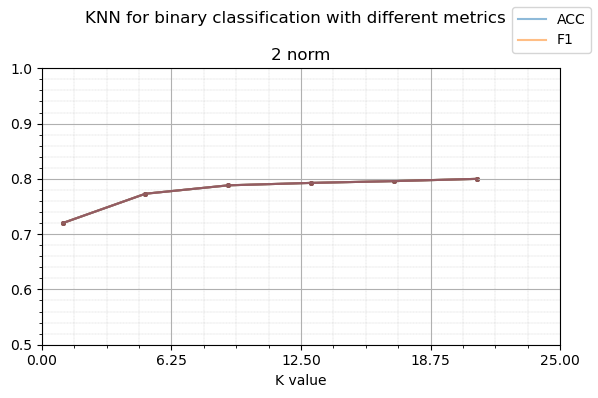

In [27]:
mpl.rcParams['figure.dpi'] = 100
for j in range(0,no_of_tests+1):
    metric=j
    plt.subplot(2,1,j+1)
    plotter(x_graph[j],ACCscores[j],F1scores[j],str(metric)+" norm","K value",first=(j==0))
    plt.xticks(np.linspace(0, k_max, 5))

plt.suptitle("KNN for binary classification with different metrics")
plt.tight_layout()

#plt.figlegend(['AUC', 'ACC', 'F1'])

plt.show()

In [28]:
print("best metrics according to ACC")
count=0
for i in np.argsort(ACCscores,axis=None,)[-3:]:
    best_metric,best_k =int( i//k_max), int(i%k_max    )
    best_score = ACCscores[int(best_metric)][int(best_k)]
    if best_metric==0:
        best_metric =-math.inf
    elif best_metric==no_of_tests-1:
        best_metric = math.inf
    print('\t'+str(3-count)+" best metric is ", best_metric,"(k=",best_k,")with a score of ",best_score)
    if 3-count==1:
        best_methods_AUC["KNN" + "(metric=" + str(best_metric) + ", k=" + str(best_k)]=best_score
    count+=1
%reset_selective -f AUCscores ACCscores F1scores x_graph k_max no_of_tests metric j k test_pred best_metric best_k best_score

best metrics according to ACC
	3 best metric is  inf (k= 13 )with a score of  0.7927506577024261
	2 best metric is  inf (k= 17 )with a score of  0.7959660917860275
	1 best metric is  inf (k= 21 )with a score of  0.8000584624378837


<h2>Linear Regression </h2>


In [ ]:
train_labels1 = one_hot_encoding(train_labels)
test_labels1 = one_hot_encoding(test_labels)

k_max=20

x_graph = np.zeros(k_max)
AUCscores = np.zeros(x_graph.shape)
ACCscores = np.zeros(x_graph.shape)
F1scores = np.zeros(x_graph.shape)

for k in range(0, k_max):

    y_predonehot = regression_classifier(train_images, train_labels1, test_images, lambda_hyper=100*math.exp(-k))
    test_pred = np.argmax(y_predonehot, axis=1)
    x_graph[k] = k
    F1scores[k] =metrics.f1_score(test_labels,test_pred,average='weighted')
    ACCscores[k] =metrics.accuracy_score(test_labels,test_pred)
    print(k,metrics.accuracy_score(test_labels,test_pred))
    #AUCscores[j,k] =metrics.roc_auc_score(test_labels,test_pred,multi_class='ovr')

best metrics according to AUC


TypeError: type numpy.ndarray doesn't define __round__ method

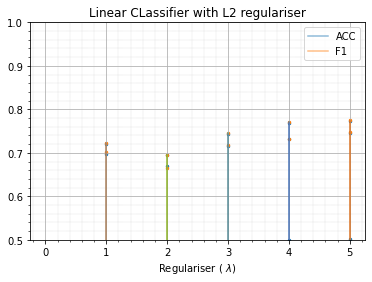

In [15]:
plotter(x_graph, ACCscores, F1scores, "Linear CLassifier with L2 regulariser", "Regulariser ( $\lambda $) ")
plt.legend([ 'ACC', 'F1']);
count = 0
print("best metrics according to AUC")
for i in np.argsort(AUCscores, axis=None, )[-3:]:

    best_score = AUCscores[i]

    print('\t' + str(3 - count) + " best regulariser is  ", round(x_graph[i], 3), "With score", round(best_score, 3))
    if 3 - count == 1:
        best_methods_AUC["Least squares with regulariser ", x_graph[i]] = best_score
    count += 1
print("best metrics according to ACC")
count = 0

for i in np.argsort(ACCscores, axis=None, )[-3:]:

    best_score = ACCscores[i]

    print('\t' + str(3 - count) + " best regulariser is  ", round(x_graph[i], 3), "With score", round(best_score, 3))
    if 3 - count == 1:
        best_methods_ACC["Least squares with regulariser ", x_graph[i]] = best_score
    count += 1

% reset_selective -f AUCscores ACCscores F1scores x_graph k_max test_pred  best_s<h2>core

<h2>Logistic Regression</h2>


In [134]:
train_labels1 = one_hot_encoding(train_labels)
test_labels1 = one_hot_encoding(test_labels)
pred_labels = np.zeros(test_labels1.shape)
T=Trainer()

def concat_one(images):
    ones = np.ones((np.shape(images)[0],1))
    images = np.append(images, ones, axis=1)
    return images
tr_data=concat_one(train_images)
te_data=concat_one(test_images)
T.Logistic_trained = False

reg=[0.01,0.02,0.1,1,10]
acc=[]
f1=[]
for regs in reg:
    for j in range(8):
        T.Logistic_trained = False
        tr=train_labels1[:,j]
        w=T.Logistic_Train(tr_data, tr, 0.1, 100, 0, regs)
        pred_labels[:,j]=np.dot(w.T,te_data.T).T
    test_pred = np.argmax(pred_labels, axis=1)
    acc.append(metrics.accuracy_score(test_labels,test_pred))
    f1.append(metrics.f1_score(test_labels,test_pred,average='macro'))

(11959, 2353)


C:\Users\Sudhanshu\AppData\Local\Temp/ipykernel_22136/3266747371.py:67: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.ones(len(labels), dtype=np.int)


(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)


C:\Users\Sudhanshu\AppData\Local\Temp/ipykernel_22136/3266747371.py:67: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.ones(len(labels), dtype=np.int)


(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)


C:\Users\Sudhanshu\AppData\Local\Temp/ipykernel_22136/3266747371.py:67: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.ones(len(labels), dtype=np.int)


(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)


C:\Users\Sudhanshu\AppData\Local\Temp/ipykernel_22136/3266747371.py:67: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.ones(len(labels), dtype=np.int)


(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)


C:\Users\Sudhanshu\AppData\Local\Temp/ipykernel_22136/3266747371.py:67: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.ones(len(labels), dtype=np.int)


(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)
(11959, 2353)


In [114]:
train_labels1 = one_hot_encoding(train_labels)
test_labels1 = one_hot_encoding(test_labels)
pred_labels = np.zeros(test_labels1.shape)
# we try alloting a guassian to each label
guassians=[]
# we spilt the training data into 8 classes, each set having one label

for i in range(0,8):
    #first we find all points for which the label is i
    points=np.squeeze(train_images[(np.argwhere((train_labels.flatten())==i))])
    guassians.append([np.mean(points,axis=0),np.cov(points,rowvar=False)])
    pred_labels[:,i]=multivariate_normal(guassians[i][0],guassians[i][1],allow_singular=True).pdf(test_images)


[0.9101143  0.7924264  0.74508697 ... 0.8974979  0.77102864 0.73273385]


C:\ProgramData\Anaconda3\envs\MLcoding\lib\site-packages\scipy\stats\_multivariate.py:744: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logpdf(x))


[0.90435636 0.7779227  0.73118925 ... 0.88755375 0.7649818  0.71925074]
[0.92370534 0.8121557  0.72989815 ... 0.9202898  0.79868555 0.7454576 ]
[0.890437   0.7698685  0.74200517 ... 0.88245326 0.7591916  0.72341394]
[0.91083115 0.7951384  0.6992303  ... 0.89894193 0.7733555  0.72939664]
[0.8847791  0.7555218  0.7319615  ... 0.87956977 0.7548072  0.71381474]
[0.892615   0.7706747  0.71393496 ... 0.88370085 0.75609046 0.7175921 ]
[0.92084205 0.8039089  0.7325504  ... 0.9198793  0.79807496 0.73703474]


In [125]:
test_pred = np.argmax(pred_labels, axis=1)
print(metrics.accuracy_score(test_labels,test_pred.T))
print(metrics.f1_score(test_labels,test_pred.T,average='macro'))


0.18357205495469162
0.1415789322678105


AxisError: axis 1 is out of bounds for array of dimension 1

In [149]:
def Parzen_Return(x, data, labels, window_size):
    print(1)
    Y_test_predicted= np.zeros(x.shape[0])
    for j in range(x.shape[0]):
        # we find the label of the point
        if(j%2==0):
            print(j)
        inside_window_list = []
        while not len(inside_window_list):
            for i in range(len(data)):
                if np.max(np.absolute(x-data[i])) < window_size:
                    inside_window_list.append(i)
            window_size *= 2

        Y_test_predicted[j] = np.argmax(np.bincount(np.squeeze(labels[inside_window_list])))
    return Y_test_predicted
print(10)
pred=Parzen_Return(test_images[0:100,:],train_images,train_labels,0.1)

10
1
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98


In [152]:
accuracy=metrics.accuracy_score(test_labels[0: 100],pred)
f1=metrics.f1_score(test_labels[0: 100],pred,average='macro')
print(accuracy)
print(f1)

0.17
0.036637931034482756
